# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

I'll use `photoeccentric` to implement nested sampling with `dynesty`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares

# Using emcee & corner to find and plot (e, w) distribution with MCMC
import emcee
import corner

# Using dynesty to do the same with nested sampling
import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

# pandas display option
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [3]:
nwalk = 64
nsteps = 1000
ndiscard = 500
arrlen = (nsteps-ndiscard)*nwalk

I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [4]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

I'm reading in several .csv files containing data for this sample. The data includes spectroscopy data from Muirhead et al. (2013), stellar and planet parameters from the Kepler archive, and distances/luminosities from Gaia. 

In [10]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = pd.read_csv('datafiles/database/spectplanets.csv')

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = pd.read_csv("datafiles/database/muirhead_gaia.csv")

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.read_csv('datafiles/database/muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = pd.read_csv('datafiles/database/muirhead_comb_lums.csv')

# Defining a "test planet"

I'm going to pick a planet from our sample to test how well `photoeccentric` works. Here, I'm picking KOI 947 (Kepler-737 b), a super-Earth orbiting an M dwarf [Exoplanet Catalog Entry](https://exoplanets.nasa.gov/exoplanet-catalog/2457/kepler-1582-b/). It has an orbital period of about 5 days.

First, I'll use the spectroscopy data from Muirhead et al. 2013 and Gaia luminosities to constrain the mass and radius of the host star beyond the constraint published in the Exoplanet Archive. I'll do this by matching these data with stellar isochrones [MESA](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/102) (check this ciation) and using the masses/radii from the matching isochrones to constrian the stellar density.

In [29]:
# Kepler ID for Kepler-1582 b
kepid = 9710326
KOI = 947
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]
koiname = spectplanets.loc[spectplanets['kepid'] == kepid].kepoi_name.values[0]

kp737b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

I'll read in a file with MESA isochrones. I'll use `ph.fit_isochrone_lum()` to find the subset of stellar isochrones that are consistent with a certain stellar parameters form Kepler-737 (Teff, Mstar, Rstar, and Gaia luminosity). 

In [30]:
# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

Using `ph.fit_isochrone_lum()` to match isochrones to stellar data:

In [31]:
iso_lums = ph.fit_isochrone_lum(kp737b, isochrones, gaia_lum=True, source='Muirhead')

100%|██████████| 738479/738479 [00:28<00:00, 26064.83it/s] 


In [32]:
# Write to csv, then read back in (prevents python notebook from lagging)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

In [33]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

I'm determining the mass and radius constraints of this star based on the isochrones that were consistent with the data above.

In [34]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

Now, I'm using `ph.find_density_dist_symmetric()` to create a stellar density distribution from symmetric (Gaussian) distributions based on Mstar and Rstar from isochrones.


Note: this does not necessarily mean the resulting density distribution will appear symmetric.

In [35]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

Text(0.5, 0, 'Stellar Density Histogram (kg m^-3)')

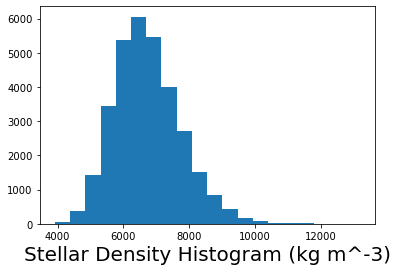

In [36]:
plt.hist(rho_star, bins=20)
plt.xlabel('Stellar Density Histogram (kg m^-3)', fontsize=20)

# Creating a fake light curve based on a real planet

I'm pulling the planet parameters of Kepler-737 b from the exoplanet archive using `ph.planet_params_from_archive()`. This will give me the published period, Rp/Rs, and inclination constraints of this planet. (It will also return some other parameters, but we don't need those right now).

I'm calculating a/Rs using `ph.calc_a()`, instead of using the a/Rs constraint from the Exoplanet Archive. The reason is because a/Rs must be consistent with the density calculated above from spectroscopy/Gaia for the photoeccentric effect to work correctly, and the published a/Rs is often inconsistent. a/Rs depends on the orbital period, Mstar, and Rstar.

In [37]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, koiname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.48797798116154106 Stellar radius (Rsun):  0.4690682721275218
Period (Days):  28.59914031 Rp/Rs:  0.036375
a/Rs:  65.99499728728715
i (deg):  89.99


Now, I'll create a fake transit using `batman`.
I'm creating a model with the period, Rp/Rs, a/Rs, and inclination specified by the Kepler catalog entry and the density constraints.

I'll create the transit model with an $e$ and $w$ of my choice. This will allow me to test whether `photoeccentric` accurately recovers the $(e,w)$ combination I have input. I'll start with $e = 0.0$ and $w = 90.0$ degrees.

## $e = 0.0$, $\omega = 90.0$

I need to define a cadence length (~30  minutes, in days) that matches the Kepler long-cadence integration time, so I can create a fake light curve that integrates over the same time as real Kepler light curves.

In [38]:
# 30 minute cadence
cadence = 0.02142857142857143

time = np.arange(-300, 300, cadence)

The function `ph.integrate_lcfitter()` evaluates flux at every minute, than sums over every 30 minutes to simultae the Kepler integration time.

In [39]:
# Define e and w, calculate flux from transit model
e = 0.0
w = 90.0
flux = ph.integratedlc(time, period, rprs, a_rs, 0.0, i, 90.0, 0)

# Adding some gaussian noise on the order of Kepler noise (by eyeball)
noise = np.random.normal(0,0.0005,len(time))
nflux = flux+noise

flux_err = np.array([0.0005]*len(nflux))

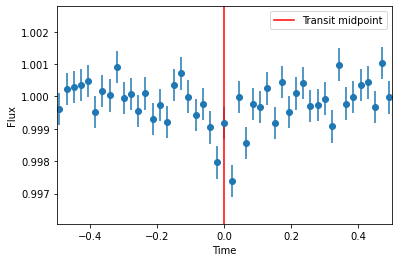

In [40]:
plt.errorbar(time, nflux, yerr=flux_err, fmt='o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(-0.5, 0.5)
plt.axvline(0.0, c='r', label='Transit midpoint')
plt.legend()

In [41]:
transitmpt = 0

midpoints = np.unique(np.sort(np.concatenate((np.arange(transitmpt, time[0], -period), np.arange(transitmpt, time[-1], period)))))

## Fitting the transit

`photoeccentric` includes functionality to fit with MCMC (`emcee`) or nested sampling (`dynesty`).

First, I'll fit the transit shape with `emcee`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e is not 0, the transit fitter will fit the "wrong" values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values close to the Kepler archive parameters.

##### Removing Out of Transit Data

In [45]:
ttime = []
tflux = []
tflux_err = []

for i in range(len(midpoints)):

    m, b, t1bjd, t1, fnorm, fe1 = ph.do_linfit(time, nflux, flux_err, midpoints[i], 11, 5)
    ttime.append(t1bjd)
    tflux.append(fnorm)
    tflux_err.append(fe1)
    

ttime = np.array(ttime).flatten()
tflux = np.array(tflux).flatten()
tflux_err = np.array(tflux_err).flatten()

tflux = np.nan_to_num(tflux, nan=1.0)
tflux_err = np.nan_to_num(tflux_err, nan=np.nanmedian(tflux_err))

<ErrorbarContainer object of 3 artists>

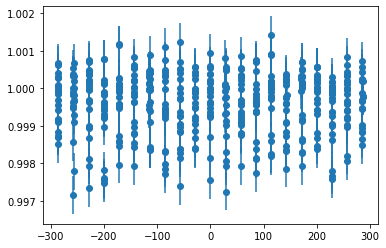

In [46]:
plt.errorbar(ttime, tflux, yerr=tflux_err, fmt='o')

In [48]:
priortransform = [3., 27., 1., 0., 15., 64., 2., 88., 0.1, transitmpt]
nbuffer = 11

ms, bs, timesBJD, timesPhase, fluxNorm, fluxErrs, rpDists, arsDists, incDists, t0Dist = ph.fit_keplc_emcee(KOI, midpoints, ttime, tflux, tflux_err, 64, 3000, 500, 11, spectplanets, muirhead_comb)


dfkjsaflajsbflasjbfalsjb
kepoiname K00947.01
Stellar mass (Msun):  0.48797798116154106 Stellar radius (Rsun):  0.4690682721275218
Period (Days):  28.59914031 Rp/Rs:  0.036375
a/Rs:  65.99499728728715
i (deg):  89.99


/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/lcfitter.py:625: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos = solnx + 1e-4 * np.random.randn(nwalk, 5)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
perDists

In [ ]:
np.savetxt('Speriods.csv', perDists, delimiter=',')
np.savetxt('Srprs.csv', rpDists, delimiter=',')
np.savetxt('Sars.csv', arsDists, delimiter=',')
np.savetxt('Sinc.csv', incDists, delimiter=',')

np.savetxt('St0.csv', t0Dists, delimiter=',')

In [ ]:
per_f = ph.mode(perDists)
rprs_f = ph.mode(rpDists)
a_f = ph.mode(arsDists)
i_f = ph.mode(incDists)
t0_f = ph.mode(t0Dists)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

In [ ]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f, t0_f)

In [ ]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [ ]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

# Get $g$

Finally, we can use all the values above to determine $\rho_{circ}$. $\rho_{circ}$ is what we would calculate the stellar density to be if we knew that the orbit was definitely perfectly circular. We  will compare $\rho_{circ}$ to $\rho_{star}$ (the true, observed stellar density we calculated from spectroscopy/Gaia), and get $g(e, w)$:
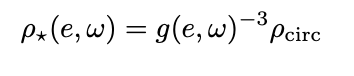

which is also defined as 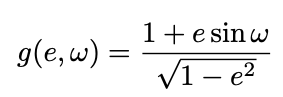

Thus, if the orbit is circular $(e = 0)$, then $g$ should equal 1. If the orbit is not circular $(e != 0)$, then $\rho_{circ}$ should differ from $\rho_{star}$, and $g$ should be something other than 1. We can draw a $(e, w)$ distribution based on the value we calcaulte for $g(e,w)$!

`ph.get_g_distribution()` will help us determine the value of g. This function takes the observed $\rho_{star}$ as well as the fit (circular) transit parameters and calculated transit durations, and calculates $\rho_{circ}$ and $g(e,w)$ based on equations 6 and 7 in [Dawson & Johnson 2012](https://arxiv.org/pdf/1203.5537.pdf).

In [30]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

Print $g$ and $\sigma_{g}$:

In [31]:
g_mean

0.9334738023122277

In [32]:
g_sigma

0.15406886484256177

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [33]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [34]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:04<00:00, 1215.65it/s]


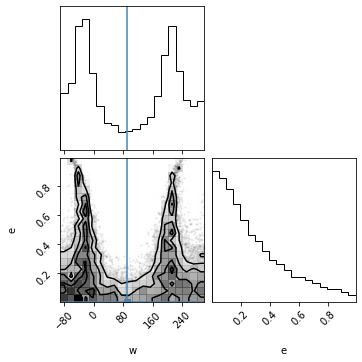

In [35]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, title_kwargs={"fontsize": 12}, truths=[w, e], plot_contours=True)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!

# $e=0.9$, $w=-90.0$

Let's do that again, but this time I'll do an eccentric orbit: e = 0.3 and w = 90.

In [86]:
time = np.arange(-25, 25, cadence)

In [87]:
# Calculate flux from transit model
e = 0.9
w = -90.0
flux = ph.integratedlc(time, period, rprs, a_rs, 0.9, i, -90.0)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

## Fitting the transit

Using astropy BLS:

In [88]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [89]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF

Period fit:  4.828282828282829


Now, I'm fitting the transit shape with `emcee`. $Rp/Rs$, $a/Rs$, $i$, and $w$ are allowed to vary as free parameters. 

The transit fitter, `ph.planetlc_fitter`, fixes $e = 0.0$, even if the input eccentricity is not zero! This means that if e != 0, the transit fitter will fit the wrong values for $a/Rs$ and $i$ -- but they will be wrong in such a way that reveals the eccentricity of the orbit. More on that in the next section.

I enter an initial guess based on what I estimate the fit parameters will be. For this one, I'll enter values pretty close to what I input.

In [90]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time1, nflux1, fluxerr1 = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

In [91]:
mid = ph.get_mid(time1)
ptime1 = ph.get_ptime(time1, mid, 29)

And fitting the transit using `ph.planetlc_fitter()`.

As explained above, because here the true eccentricity of the orbit is not zero, the transit fitter should fit the wrong values for $a/Rs$ and $i$ in a way that reveals the eccentricity of the orbit.

I enter an initial guess based on what I estimate the fit parameters will be: here, I'll try guesses for $a/Rs$ and $i$ that are slightly larger and smaller than the true values, respectively.

In [92]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 45, 89.0]

dr = 'e_' + str(0.3) + '_w_' + str(w)
direct = 'plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, pdist, rdist, adist, idist = ph.mcmc_fitter(p0, time1, ptime1, nflux1, fluxerr1, nwalk, nsteps, ndiscard, e, w, direct)



100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


In [93]:
per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

In [94]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314


Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


Fit params:
Rp/Rs:  0.03618336853229516
a/Rs:  7.735990137192752
i (deg):  89.89838321984138


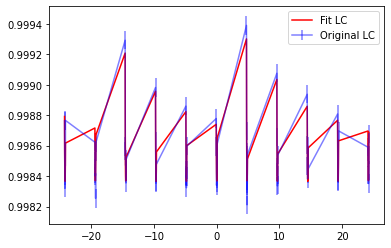

In [95]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

We need to calculate T14 and T23 again, and this time they should differ from the true transit durations because the equations we're using require $e = 0$, and we've input $e = 0.3$.

In [96]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

And now, we're getting $g$ in the same way as above, using `ph.get_g_distribution()`. 

In [97]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

Print $g$ and $\sigma_{g}$:

In [98]:
g_mean

0.22054168457010248

In [99]:
g_sigma

0.02440018331656517

The mean of $g$ is not 1 this time. It's about 1.3, which means that $\rho_{circ}$ differs from $\rho_{star}$ and the eccentricity of this transit must NOT be zero! This is good. Let's take $g$ and $\sigma_{g}$ and use MCMC again to see if the most likely $e$ is 0.3, as we input.

In [100]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [101]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:06<00:00, 771.08it/s] 


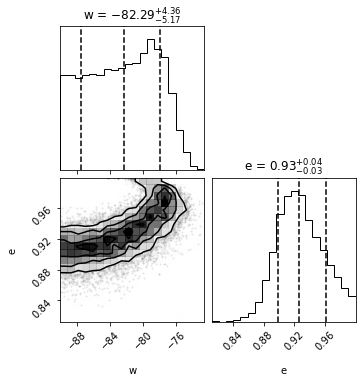

In [102]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[90.0, 0.3], quantiles=[0.16, 0.5, 0.84], plot_contours=True)

Here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1.3$. This $e$ distribution peaks at about 0.3, which is exactly what we expect based on the transit we created!

# $e=0.3$, $w=-90.0$

Let's do one more, this time a planet with the same eccentricity $e = 0.3$, but where the longitude of periastron $\omega$ is -90 deg (insteadl of 90 deg). This means that this planet would be passing in front of the star (from our perspective) at the "long" side of its orbital ellipse, instead of the "short" side. A planet with $\omega = -90$ will produce the longest transit possible, while a planet with $\omega = +90$ will produce the shortest transit possible, assuming that all other parameters are the same. 

`photoeccentric` should catch onto this, and produce an $(e, w)$ surface that corresponds to the most likely $w$.

In [66]:
time = np.arange(-25, 25, cadence)

In [67]:
# Calculate flux from transit model
e = 0.3
w = -90.0
flux = ph.integratedlc(time, period, rprs, a_rs, 0.3, i, -90.0)

# Adding some gaussian noise
noise = np.random.normal(0,0.00006,len(time))
nflux = flux+noise

flux_err = np.array([0.00006]*len(nflux))

(-1.0, 1.0)

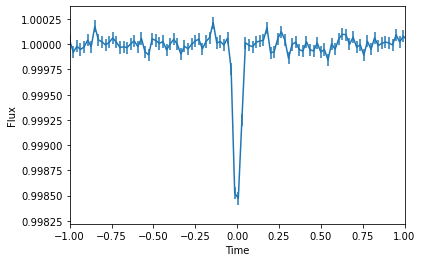

In [68]:
plt.errorbar(time, nflux, yerr=flux_err)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.xlim(-1, 1)

## Fitting the transit

Using astropy BLS:

In [69]:
periodPDF = ph.get_period_dist(time, nflux, 4, 6, arrlen)

In [70]:
print('Period fit: ', ph.mode(periodPDF))
pdist = periodPDF

Period fit:  4.828282828282829


And fitting the transit using `ph.planetlc_fitter()`.

The true eccentricity of this orbit is again not zero, so the transit fitter should fit the wrong values for $a/Rs$ and $i$ in a way that reveals the eccentricity of the orbit.

I enter an initial guess based on what I estimate the fit parameters will be: here, I'll try guesses for $a/Rs$ and $i$ that are slightly smaller than both of these true values.

In [71]:
ttimes = np.concatenate((-np.arange(0, time[-1], period)[1:], np.arange(0, time[-1], period)))
ttimes = np.sort(ttimes)

time1, nflux1, fluxerr1 = ph.get_transit_cutout_full(ttimes, 4, time, nflux, flux_err)

In [72]:
mid = ph.get_mid(time1)
ptime1 = ph.get_ptime(time1, mid, 29)

In [75]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [per_guess, rprs, 20, 89]

dr = 'e_' + str(e) + '_w_' + str(w)
direct = 'plots_tutorial/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, pdist, rdist, adist, idist = ph.mcmc_fitter(p0, time1, ptime1, nflux1, fluxerr1, nwalk, nsteps, ndiscard, e, w, direct)



100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


In [76]:
per_f = ph.mode(pdist)
rprs_f = ph.mode(rdist)
a_f = ph.mode(adist)
i_f = ph.mode(idist)

In [77]:
# Create a light curve with the fit parameters
fit1 = ph.integratedlc_fitter(time1, per_f, rprs_f, a_f, i_f)

Printing the original and fit parameters, and plotting the original and fit light curves:

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314


Input params:
Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


Fit params:
Rp/Rs:  0.03593573547157472
a/Rs:  24.3509176108585
i (deg):  89.57491555940267


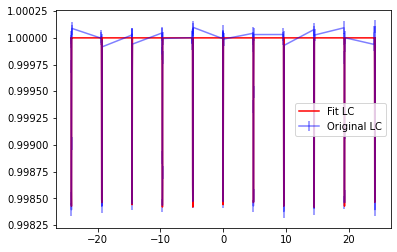

In [78]:
plt.errorbar(time1, nflux1, yerr=fluxerr1, c='blue', alpha=0.5, label='Original LC')
plt.plot(time1, fit1, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(-0.1, 0.1)
plt.legend()

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)

print('\n')

print('Input params:')
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

print('\n')

print('Fit params:')
print('Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)

We need to calculate T14 and T23 again, and this time they should differ from the true transit durations because the equations we're using require $e = 0$, and we've input $e = 0.3$. 

How will `ph.get_T14()` and `ph.get_T23()` know that the planet is transiting at apoapse ($\omega = -90$) instead of periapse ($\omega = 90$)? Because the fit values for $a/Rs$ and $i$ compensate for the change in transit duration! All the information we need is encoded into the fit $a/Rs$ and $i$.

In [79]:
T14dist = ph.get_T14(pdist, rdist, adist, idist)
T14errs = ph.get_sigmas(T14dist)

T23dist = ph.get_T23(pdist, rdist, adist, idist)
T23errs = ph.get_sigmas(T23dist)

In [80]:
gs, rho_c = ph.get_g_distribution(rho_star, pdist, rdist, T14dist, T23dist)

g_mean = ph.mode(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

Print $g$ and $\sigma_{g}$:

In [81]:
g_mean

0.6436179972096495

In [82]:
g_sigma

0.12388972243595184

The mean of $g$ this time is about 0.7. Again, this means that $\rho_{circ}$ differs from $\rho_{star}$ and the eccentricity must not be zero. 

But why is g less than 1, when in the previous example (with the same eccentricity) g was greater than 1?

Let's take $g$ and $\sigma_{g}$ and use MCMC again to see what the most likely $(e, w)$ surface looks like.

In [83]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [84]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:04<00:00, 1189.21it/s]


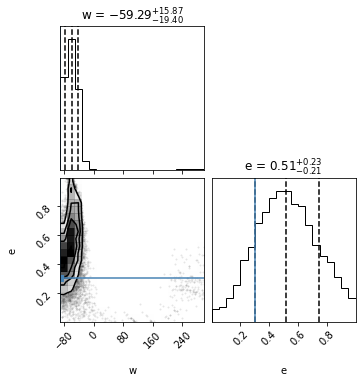

In [85]:
labels = ["w", "e"]

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[-90.0, 0.3], quantiles=[0.16, 0.5, 0.84], plot_contours=True)

In this corner plot, $e$ peaks at about 0.3 again! The $\omega$ distribution differs though -- this time, where $e = 0.3$ on this distribution, $\omega$ can equal -90. (If you look back at the previous example, $e = 0.3$ and $\omega = -90$ was inconsistent with the probability distribution in the corner plot.) So `photoeccentric` was able to accurately determine $(e, w)$ for at least these three cases!